# Gaia
## Real data!

gully  
Sept 14, 2016

### Outline:

1. More exploring

**Import these first-- I auto import them every time!:**

In [2]:
#! cat /Users/gully/.ipython/profile_default/startup/start.ipy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
import pandas as pd

In [5]:
from astropy import units as u
from astropy.coordinates import SkyCoord

### 1. Retrieve existing catalogs

Generate/retrieve data file from here:  
https://github.com/BrownDwarf/kinder

In [6]:
d1 = pd.read_csv('../../kinder/analysis/K2C02_YSO_CLN_match.csv') #local version
d2 = pd.read_csv('../../kinder/analysis/K2C02_control_kplr_match.csv') #local version

In [11]:
d2.k2_dec.isnull().sum()

2918

Fail, some don't have RA for some reason...

In [12]:
d1 = d1[~d1.k2_ra.isnull()]
d2 = d2[~d2.k2_ra.isnull()]

In [15]:
c1 = SkyCoord(d1.k2_ra.values, d1.k2_dec.values, unit=(u.deg, u.deg), frame='icrs')
c2 = SkyCoord(d2.k2_ra.values, d2.k2_dec.values, unit=(u.deg, u.deg), frame='icrs')

## 2. Read in the Gaia data

In [16]:
df_list = []

This takes a finite amount of RAM, but should be fine for modern laptops.

In [17]:
for i in range(16):
    df_list.append(pd.read_csv('../data/TgasSource_000-000-{:03d}.csv'.format(i)))

In [18]:
tt = pd.concat(df_list, ignore_index=True)

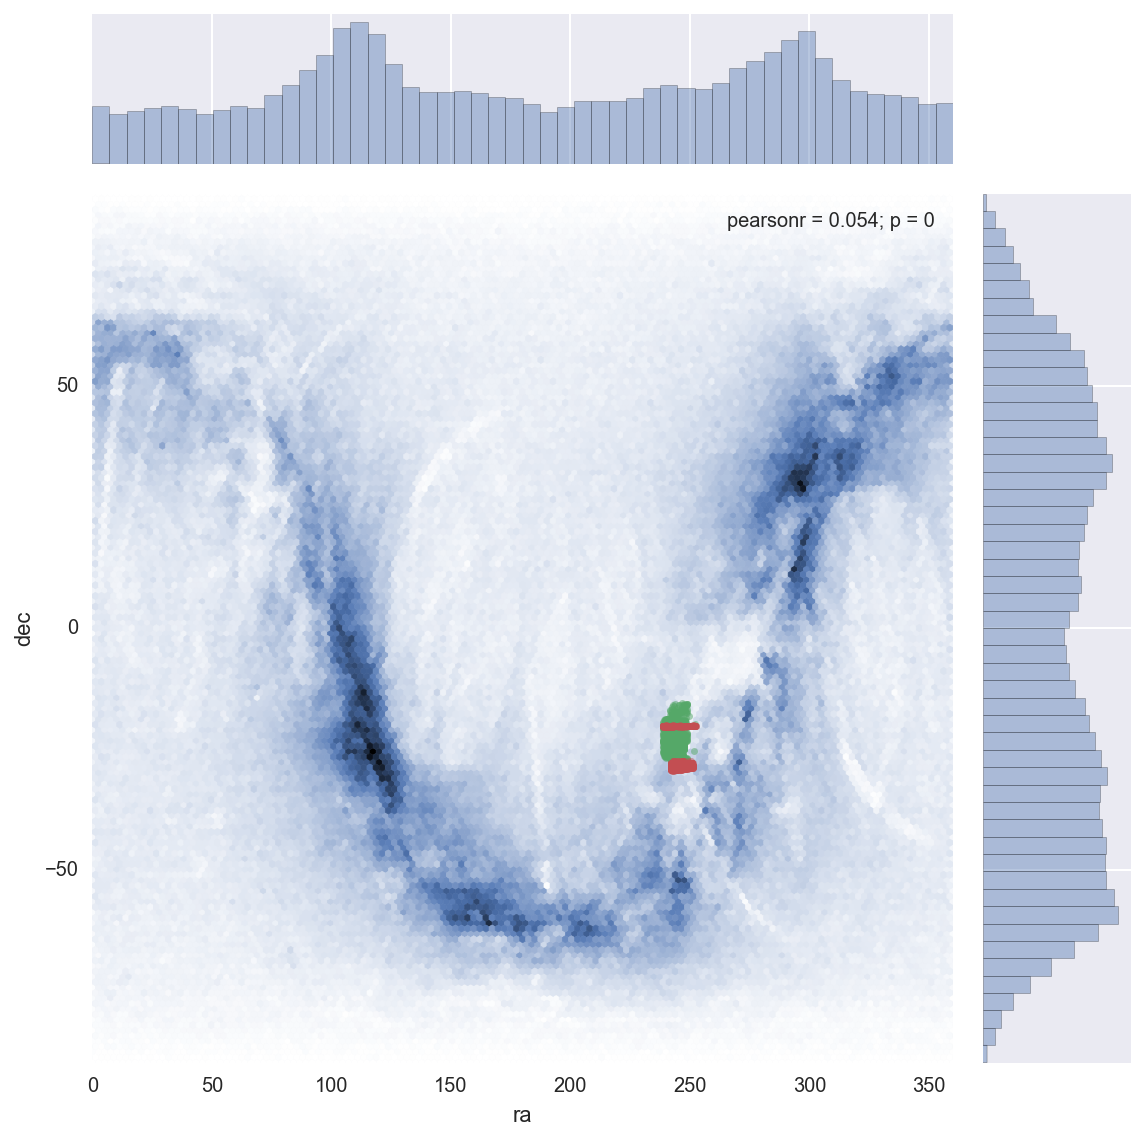

In [20]:
plt.figure(figsize=(10,4))
ax = sns.jointplot(tt.ra, tt.dec, kind='hex', size=8)
ax.ax_joint.plot(c1.ra.deg, c1.dec.deg, '.', alpha=0.5)
ax.ax_joint.plot(c2.ra.deg, c2.dec.deg, '.', alpha=0.5)

In [21]:
cg = SkyCoord(tt.ra.values, tt.dec.values, unit=(u.deg, u.deg), frame='icrs')

## Match

In [23]:
idx, d2d, blah = c1.match_to_catalog_sky(cg)
idx2, d2d2, blah2 = c2.match_to_catalog_sky(cg)

In [24]:
vec_units = d2d.to(u.arcsecond)
vec = vec_units.value
vec_units2 = d2d2.to(u.arcsecond)
vec2 = vec_units2.value

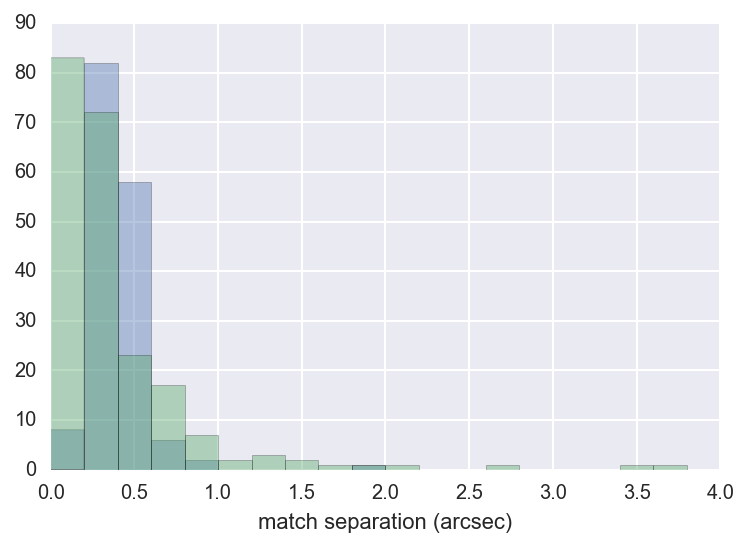

In [26]:
bins = np.arange(0, 4, 0.2)
sns.distplot(vec, bins=bins, kde=False),
sns.distplot(vec2, bins=bins, kde=False),
plt.xlim(0,4)
plt.xlabel('match separation (arcsec)')

Forced to match to nearest neighbor

In [27]:
len(set(idx)), idx.shape[0]

(768, 1658)

... yielding some redundancies in cross matching

In [28]:
tt_sub = tt.iloc[idx]
tt_sub = tt_sub.reset_index()
tt_sub = tt_sub.drop('index', axis=1)

In [29]:
d1 = d1.reset_index()
d1 = d1.drop('index', axis=1)

In [35]:
x1 = pd.concat([d1, tt_sub], axis=1)

In [30]:
tt_sub2 = tt.iloc[idx2]
tt_sub2 = tt_sub2.reset_index()
tt_sub2 = tt_sub2.drop('index', axis=1)

In [31]:
d2 = d2.reset_index()
d2 = d2.drop('index', axis=1)

In [32]:
x2 = pd.concat([d2, tt_sub2], axis=1)

In [36]:
col_order = d1.columns.values.tolist() + tt_sub.columns.values.tolist()
x1 = x1[col_order]
x0 = x1.copy()

In [38]:
col_order2 = d2.columns.values.tolist() + tt_sub2.columns.values.tolist()
x2 = x2[col_order2]
x0c = x2.copy()

In [41]:
x0['xmatch_sep_as'] = vec
x0['Gaia_match'] = vec < 2.0 #Fairly liberal, 1.0 might be better.

In [42]:
x0c['xmatch_sep_as'] = vec2
x0c['Gaia_match'] = vec2 < 2.0 #Fairly liberal, 1.0 might be better.

//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


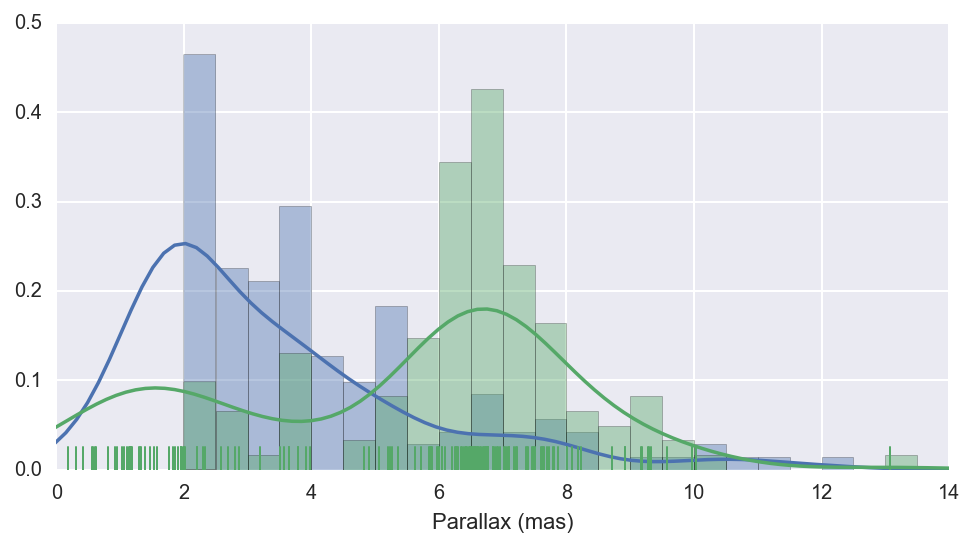

In [45]:
plt.figure(figsize=(8,4))
bins = np.arange(2, 14, 0.5)
sns.distplot(x0c.parallax[x0c.Gaia_match], bins=bins, rug=False)
sns.distplot(x0.parallax[x0.Gaia_match], bins=bins, rug=True)
#sns.distplot(1.0/(x0.parallax[x0.Gaia_match]/1000.0))
plt.xlabel('Parallax (mas)')
plt.xlim(0,14)
plt.savefig('../results/k2cycle2_gaia.png', dpi=300)

In [47]:
x0c.Gaia_match.sum(), len(d1)

(211, 1658)

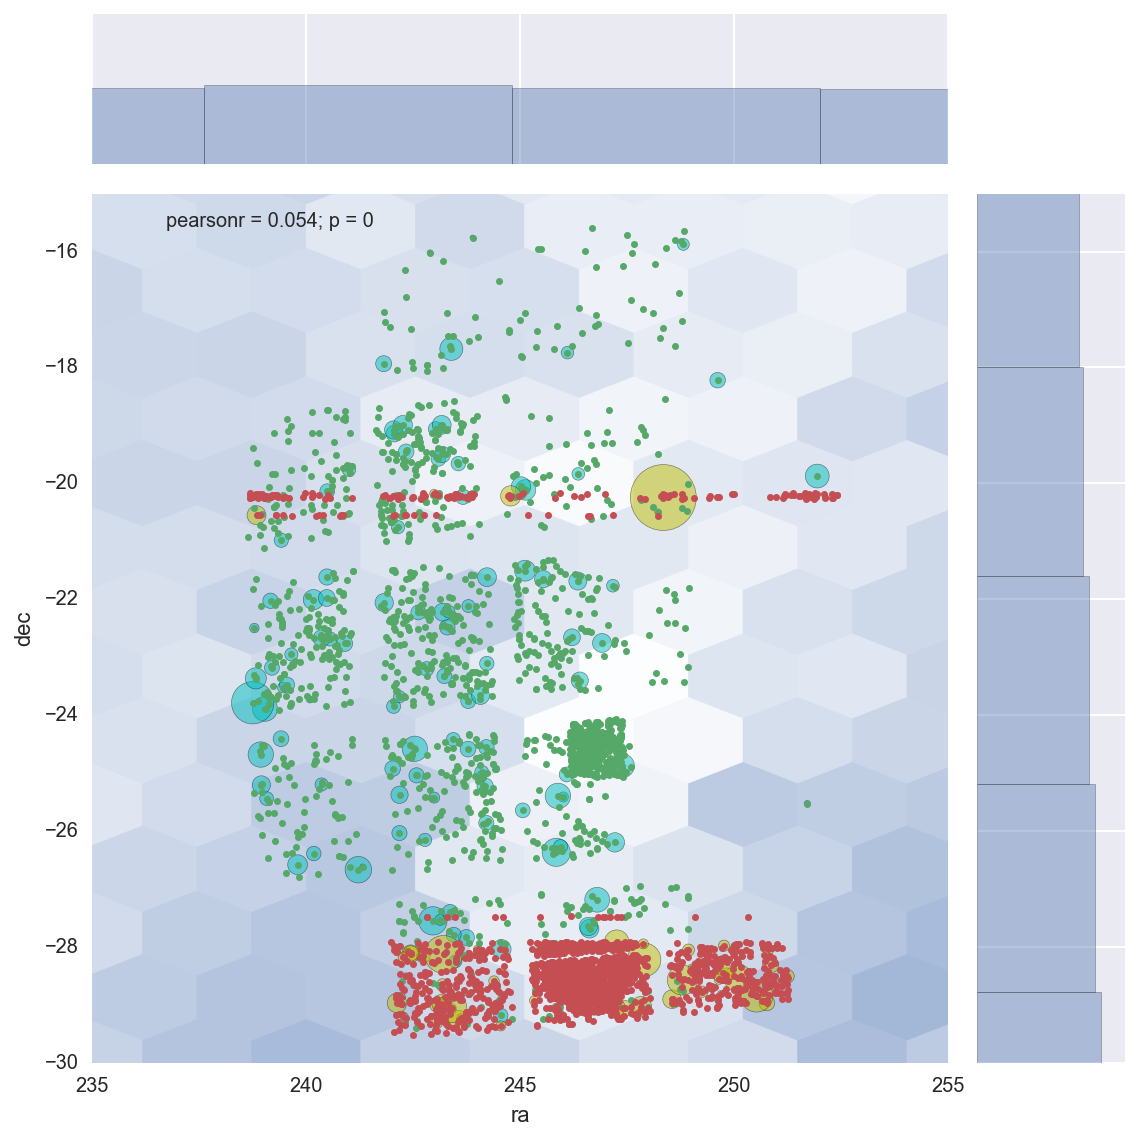

In [50]:
plt.figure(figsize=(10,4))
ax = sns.jointplot(tt.ra, tt.dec, kind='hex', size=8, xlim=(235,255), ylim=(-30,-15))
ax.ax_joint.plot(c1.ra.deg, c1.dec.deg, '.', alpha=1.0)
ax.ax_joint.plot(c2.ra.deg, c2.dec.deg, '.', alpha=1.0)
ax.ax_joint.scatter(x0.ra[x0.Gaia_match], x0.dec[x0.Gaia_match], 
                    s=x0.parallax[x0.Gaia_match]**3*0.2, c='c',alpha=0.5)
ax.ax_joint.scatter(x0c.ra[x0c.Gaia_match], x0c.dec[x0c.Gaia_match], 
                    s=x0c.parallax[x0c.Gaia_match]**3*0.2, c='y',alpha=0.5)

In [52]:
xm = x0[x0.Gaia_match]
xmc = x0c[x0c.Gaia_match]

In [72]:
xm.columns.values

array(['EPIC_ID', 'count', 'mean', 'std', 'min', '25%', '50%', '75%',
       'max', 'logstd', 'logiqr', 'fname', 'input_id', 'id', 'k2_ra',
       'k2_dec', 'twomass', 'ucac', 'tyc', 'hip', 'hip', 'kp', 'bmag',
       'vmag', 'rmag', 'imag', 'jmag', 'hmag', 'kmag', 'kepflag',
       'sim_2MASS', 'MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC',
       'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL',
       'COO_WAVELENGTH', 'COO_BIBCODE', 'OTYPE', 'ID', 'SP_TYPE',
       'SP_QUAL', 'SP_BIBCODE', 'FLUX_V', 'FLUX_I', 'FLUX_H', 'FLUX_K',
       'INPUT', 'hip', 'hip', 'tycho2_id', 'solution_id', 'source_id',
       'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr',
       'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astro

//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


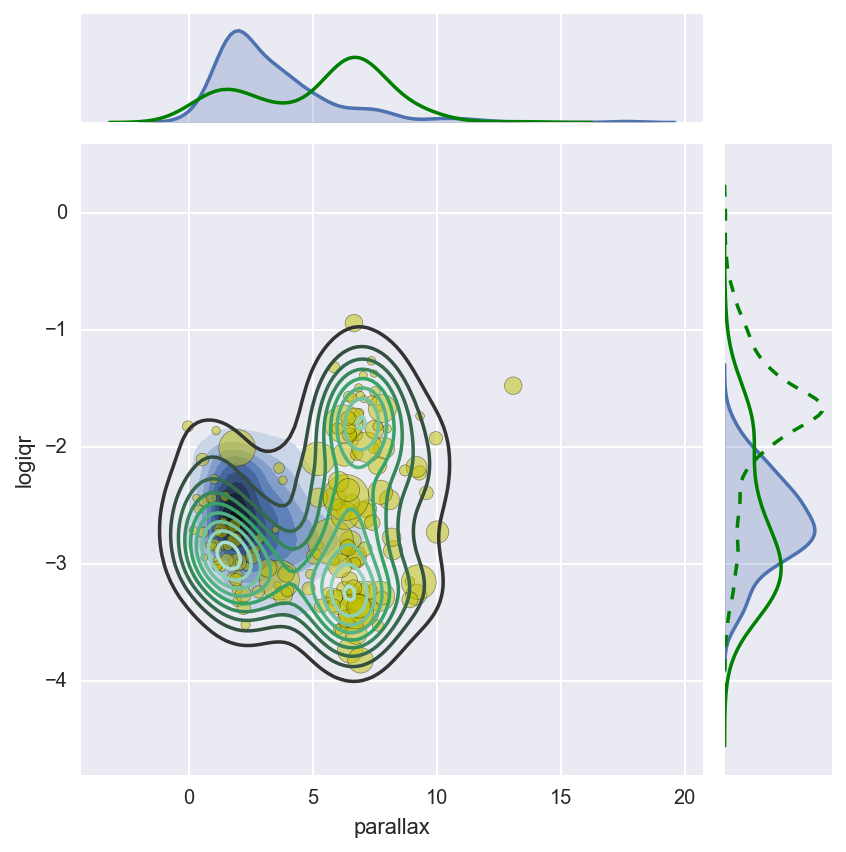

In [80]:
ax = sns.jointplot(xmc.parallax, xmc.logiqr, kind='kde', stat_func=None, joint_kws={"shade_lowest":False})
#ax.ax_joint.plot(xm.parallax, xm.logiqr, 'w.')
sns.kdeplot(xm.parallax, xm.logiqr, joint_kws={"shade":False}, ax=ax.ax_joint)
sns.kdeplot(xm.parallax.values,ax=ax.ax_marg_x, c='g')
sns.kdeplot(xm.logiqr.values,ax=ax.ax_marg_y, c='g', vertical=True)
sns.kdeplot(d1.logiqr.values,ax=ax.ax_marg_y, c='g', linestyle='--', vertical=True)
#ax.ax_joint.scatter(xm.parallax, xm.logiqr, 
#                    s=2**(10-xm.phot_g_mean_mag)*30, c='y',alpha=0.5)

In [ ]:
qid = (xm.parallax > 5.0) & (xm.parallax > 5.0)

In [71]:
xm.columns.values

array(['EPIC_ID', 'count', 'mean', 'std', 'min', '25%', '50%', '75%',
       'max', 'logstd', 'logiqr', 'fname', 'input_id', 'id', 'k2_ra',
       'k2_dec', 'twomass', 'ucac', 'tyc', 'hip', 'hip', 'kp', 'bmag',
       'vmag', 'rmag', 'imag', 'jmag', 'hmag', 'kmag', 'kepflag',
       'sim_2MASS', 'MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC',
       'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL',
       'COO_WAVELENGTH', 'COO_BIBCODE', 'OTYPE', 'ID', 'SP_TYPE',
       'SP_QUAL', 'SP_BIBCODE', 'FLUX_V', 'FLUX_I', 'FLUX_H', 'FLUX_K',
       'INPUT', 'hip', 'hip', 'tycho2_id', 'solution_id', 'source_id',
       'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr',
       'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astro

### The end.